In [1]:
from fmri.acquisitions import SparklingAcquisition
from fmri.reconstructors.base import SequentialFMRIReconstructor
from mri.operators import WaveletN 
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
from fmri.utils import ssos

In [2]:
data_file = "/volatile/pierre-antoine/optimed/meas_MID36_2D_Sparkling_1mmiso0_3s_FID3362.dat"
bin_file = "/volatile/pierre-antoine/optimed/dim2_i_RadialIO_P0.75_N192x192_FOV0.192x0.192_Nc6_Ns2688_c30_d2__D7M9Y2021T160.bin"
shifts = np.array((-22,0))


In [3]:
acq = SparklingAcquisition(data_file,bin_file,
                           frame_slicer=slice(0,10),
                           shifts=shifts,
                           calibration_kwargs={'use_frame':0})
acq

pymapVBVD version 0.4.3
Software version: VB


Scan 1/1, read all mdhs:   0%|          | 0.00/15.3G [00:00<?, ?B/s]

/home/pierre_antoine/.pyenv/versions/3.6.13/envs/fmri/lib/python3.6/site-packages/mapvbvd/mapVBVD.py:91: UserWarning: 
An unexpected read error occurred at this byte offset: 16404407168 (15.27779471874237 GiB)
Will stop reading now.

  warnings.warn(warningString)


read data:   0%|          | 0/1 [00:00<?, ?it/s]

read data:   0%|          | 0/60 [00:00<?, ?it/s]

/home/pierre_antoine/gits/phd/pysap-mri/mri/operators/fourier/utils.py:106: UserWarning: Frequencies outside the 0.5 limit will be wrapped.
  warnings.warn("Frequencies outside the 0.5 limit will be wrapped.")


SparklingAcquisition(
shots=6
samples/shots=2688
coils=32
timeframes=10
img_dim=2
img_shape=[192 192]
FOV=[0.192 0.192]
Oversampling=5
)

In [4]:
acq.kspace_data.shape, acq.kspace_loc.shape,

((10, 32, 80640), (80640, 2))

In [5]:
fourier_op = acq.get_fourier_operator(implementation='gpuNUFFT')
fourier_op.shape, fourier_op.samples, fourier_op.n_coils
mu=1e-8
regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")

linear_op = WaveletN(wavelet_name='sym8',
                    nb_scale=3,
                    dim=2,)


(32, 192, 192)


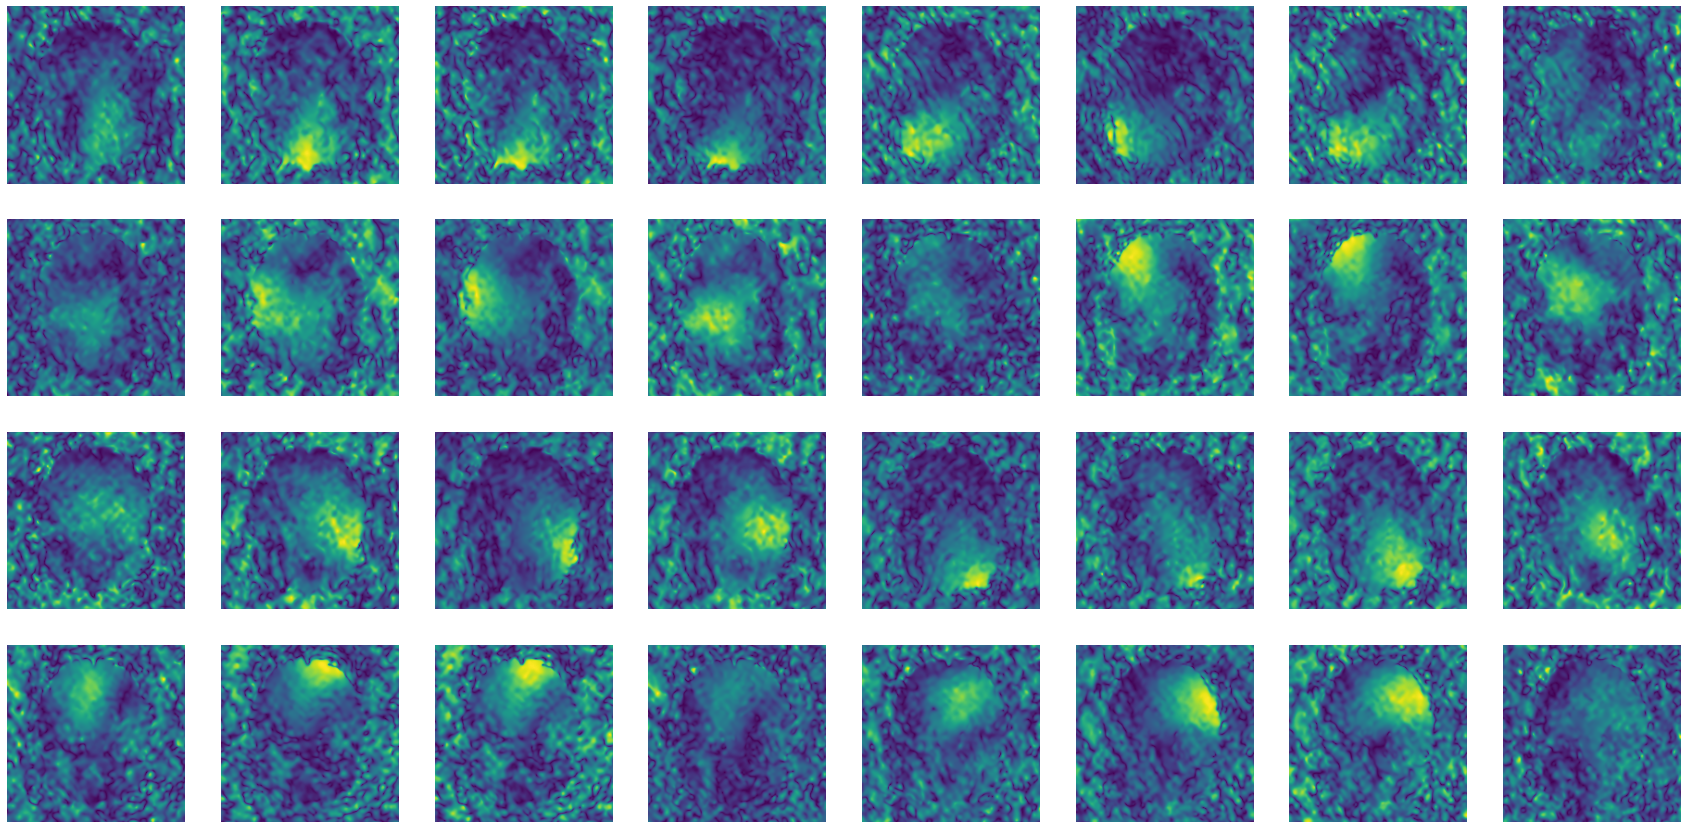

In [48]:
smaps = acq.get_smaps(mode='NFFT',density_comp=acq.density_comp)
plt.rcParams['figure.figsize'] = [30, 15]
print(smaps.shape)
fig, ax = plt.subplots(4,8)
for i in range(len(smaps)):
    ax.flatten()[i].imshow(abs(smaps[i,...]))
    ax.flatten()[i].axis('off')



In [7]:
rec = SequentialFMRIReconstructor(fourier_op, linear_op, regularizer_op, Smaps=smaps, verbose=50, optimizer='pogm')

/home/pierre_antoine/gits/phd/pysap-fmri/fmri/reconstructors/base.py:36: UserWarning: The in-time regularizer is not set. Setting to identity. Note that frame will be reconstruct independently.
  warnings.warn("The in-time regularizer is not set. Setting to identity. "


Lipschitz constant is 0.12463501179519472
The lipschitz constraint is satisfied


In [8]:
res = rec.reconstruct(acq.kspace_data)


100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100% (15 of 15) |########################| Elapsed Time: 0:00:02 Time:  0:00:02

100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


In [23]:
from IPython import display
import matplotlib.pyplot as plt
import time

In [29]:
%matplotlib inline
def dynamic_img(fmri_img, fps:float=2, normalize=True):
    """ dynamic plot of fmri data"""

    fmri_img = np.abs(fmri_img)
    if normalize:
        fmri_img *= (255.0/fmri_img.max())

    fig,ax = plt.subplots()
    obj_show = ax.imshow(np.zeros_like(fmri_img[0,:]))
    for img in fmri_img:
        obj_show.set_data(img)
        time.sleep(1./fps)
        plt.draw()

In [49]:
import matplotlib.animation as anim
fig = plt.figure()
ani = anim.ArtistAnimation(fig, res, interval=50, blit=True,
                                repeat_delay=1000)

AttributeError: 'numpy.ndarray' object has no attribute 'set_visible'

<Figure size 2160x1080 with 0 Axes>